<a href="https://colab.research.google.com/github/affanahmed373/Urdu_OCR/blob/main/Graph_image_classification_Urdu_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The notebook is mainly done for my own benefit to better understand what graph convolutional networks do on a very basic and visual task (MNIST). 

The notebook is just a slightly more visual version of the MNIST example provided at https://github.com/danielegrattarola/spektral/blob/master/examples/graph_signal_classification_mnist.py as part of the [Spektral](https://github.com/danielegrattarola/spektral) package. 

## Install Dependencies

In [1]:
!apt-get install -y graphviz libgraphviz-dev libcgraph6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
libcgraph6 is already the newest version (2.42.2-3build2).
libgraphviz-dev is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
# !pip install git+https://github.com/danielegrattarola/spektral
! pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.data import MixedLoader
from spektral.datasets.mnist import MNIST
from spektral.layers import GCNConv, GlobalSumPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor


## Libraries
Here are the libraries and imports to make the model

In [4]:
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.datasets.mnist import MNIST
from spektral.layers import GeneralConv
from spektral.utils import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

from spektral.data import MixedLoader
from spektral.datasets.mnist import MNIST
from spektral.layers import GCNConv, GlobalSumPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor

In [5]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32       # Batch size
epochs = 5        # Number of training epochs
es_patience = 200     # Patience fot early stopping

In [6]:
data = MNIST()

# The adjacency matrix is stored as an attribute of the dataset.
# Create filter for GCN and convert to sparse tensor.
data.a = GCNConv.preprocess(data.a)
data.a = sp_matrix_to_sp_tensor(data.a)

# Train/valid/test split
data_tr, data_te = data[:-10000], data[-10000:]
np.random.shuffle(data_tr)
data_tr, data_va = data_tr[:-10000], data_tr[-10000:]

# We use a MixedLoader since the dataset is in mixed mode
loader_tr = MixedLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = MixedLoader(data_va, batch_size=batch_size)
loader_te = MixedLoader(data_te, batch_size=batch_size)

N = data.

<ipython-input-6-131ead238607>:10: UserWarning: you are shuffling a 'MNIST' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(data_tr)


## Goal
The goal of the problem is to correctly classify the digits using the intensity values as the nodes and the neighborhood relationships as the edges. When we visualize the adjacency matrix we can see the effect of a simply unraveled 2D array

SparseTensor(indices=tf.Tensor(
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [783 781]
 [783 782]
 [783 783]], shape=(7180, 2), dtype=int64), values=tf.Tensor([0.11111111 0.11111111 0.10540926 ... 0.11111111 0.11111111 0.11111111], shape=(7180,), dtype=float64), dense_shape=tf.Tensor([784 784], shape=(2,), dtype=int64)) adjacency matrix


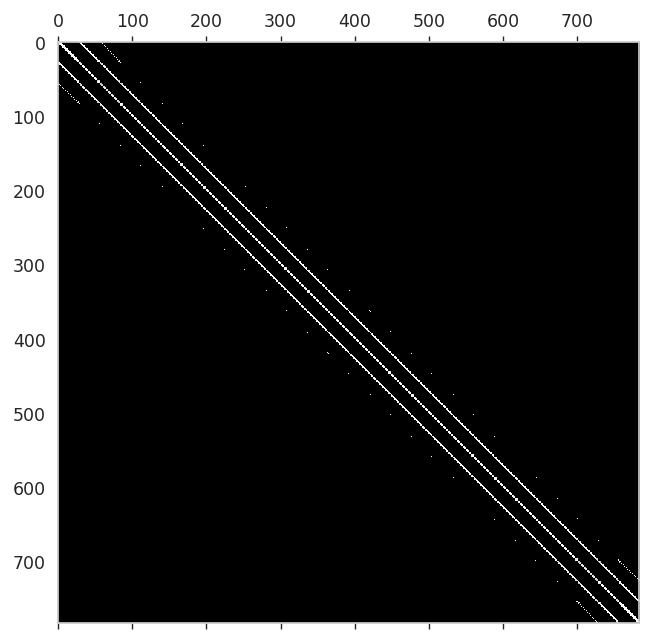

In [12]:
print(data.a, 'adjacency matrix')
plt.matshow(tf.sparse.to_dense(data.a))
# tf.sparse.to_dense(adjacency_matrix)

### Label Nodes and Show Connections
Here we can visualize the topology a bit better and see what the graph actually looks like.

In [13]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

In [16]:
print(*data.a[300])

TypeError: ignored

In [14]:
print(node_id[300], 'is connected to')
for row, col in zip(*data.a[300].nonzero()):
    print(col, '->', node_id[col])

X:20_Y:10 is connected to


TypeError: ignored

In [ ]:
G = nx.from_scipy_sparse_matrix(data.a[:10, :10])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
draw_graph_mpl(G);

- Show 12 rows of the network

In [ ]:
MAX_NODE = 28*12
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G);

- Show network (using the X, Y coordinates)

In [ ]:
G = nx.from_scipy_sparse_matrix(adj)
for k, pix_val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = ''
    G.nodes[k]['color'] = 'red' if pix_val>0.5 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));

# Model Building
Now we can build the model which uses the graph topology shown above as the basis. We feed the topology in as a constant tensor ($A_{in}$) and the convolutions occur across this topology. 

In [ ]:
fltr = normalized_laplacian(data.a)

# Model definition
X_in = Input(shape=(N, F))
# Pass A as a fixed tensor, otherwise Keras will complain about inputs of
# different rank.
A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

graph_conv_1 = GeneralConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([X_in, A_in])
graph_conv_2 = GeneralConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([graph_conv_1, A_in])
flatten = Flatten()(graph_conv_2)
fc = Dense(512, activation='relu')(flatten)
output = Dense(n_out, activation='softmax')(fc)

# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

In [ ]:
# Train model
validation_data = (X_val, y_val)
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
          callbacks=[
              EarlyStopping(patience=es_patience, restore_best_weights=True)
          ])

In [ ]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

# What did the model actually learn?
We can now try and reassemble what the model actually learnt by exporting the intermediate layers

# Weights
Not sure exactly how to interpret these but we can show them easily enough

In [ ]:
W, b = model.layers[2].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.bar(np.arange(W.shape[1]), W[0])
ax2.bar(np.arange(W.shape[1]), b)

In [ ]:
W, b = model.layers[3].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

## Show intermediate output values
Here we can rearrange the output of the graph convolutions to see if the model is learning similar sorts of features to the standard convolutional neural networks

In [ ]:
i_model = Model(inputs=[X_in, A_in], outputs=[graph_conv_1, graph_conv_2])

In [ ]:
gc1_out, gc2_out = i_model.predict(X_test[:32])

NameError: ignored

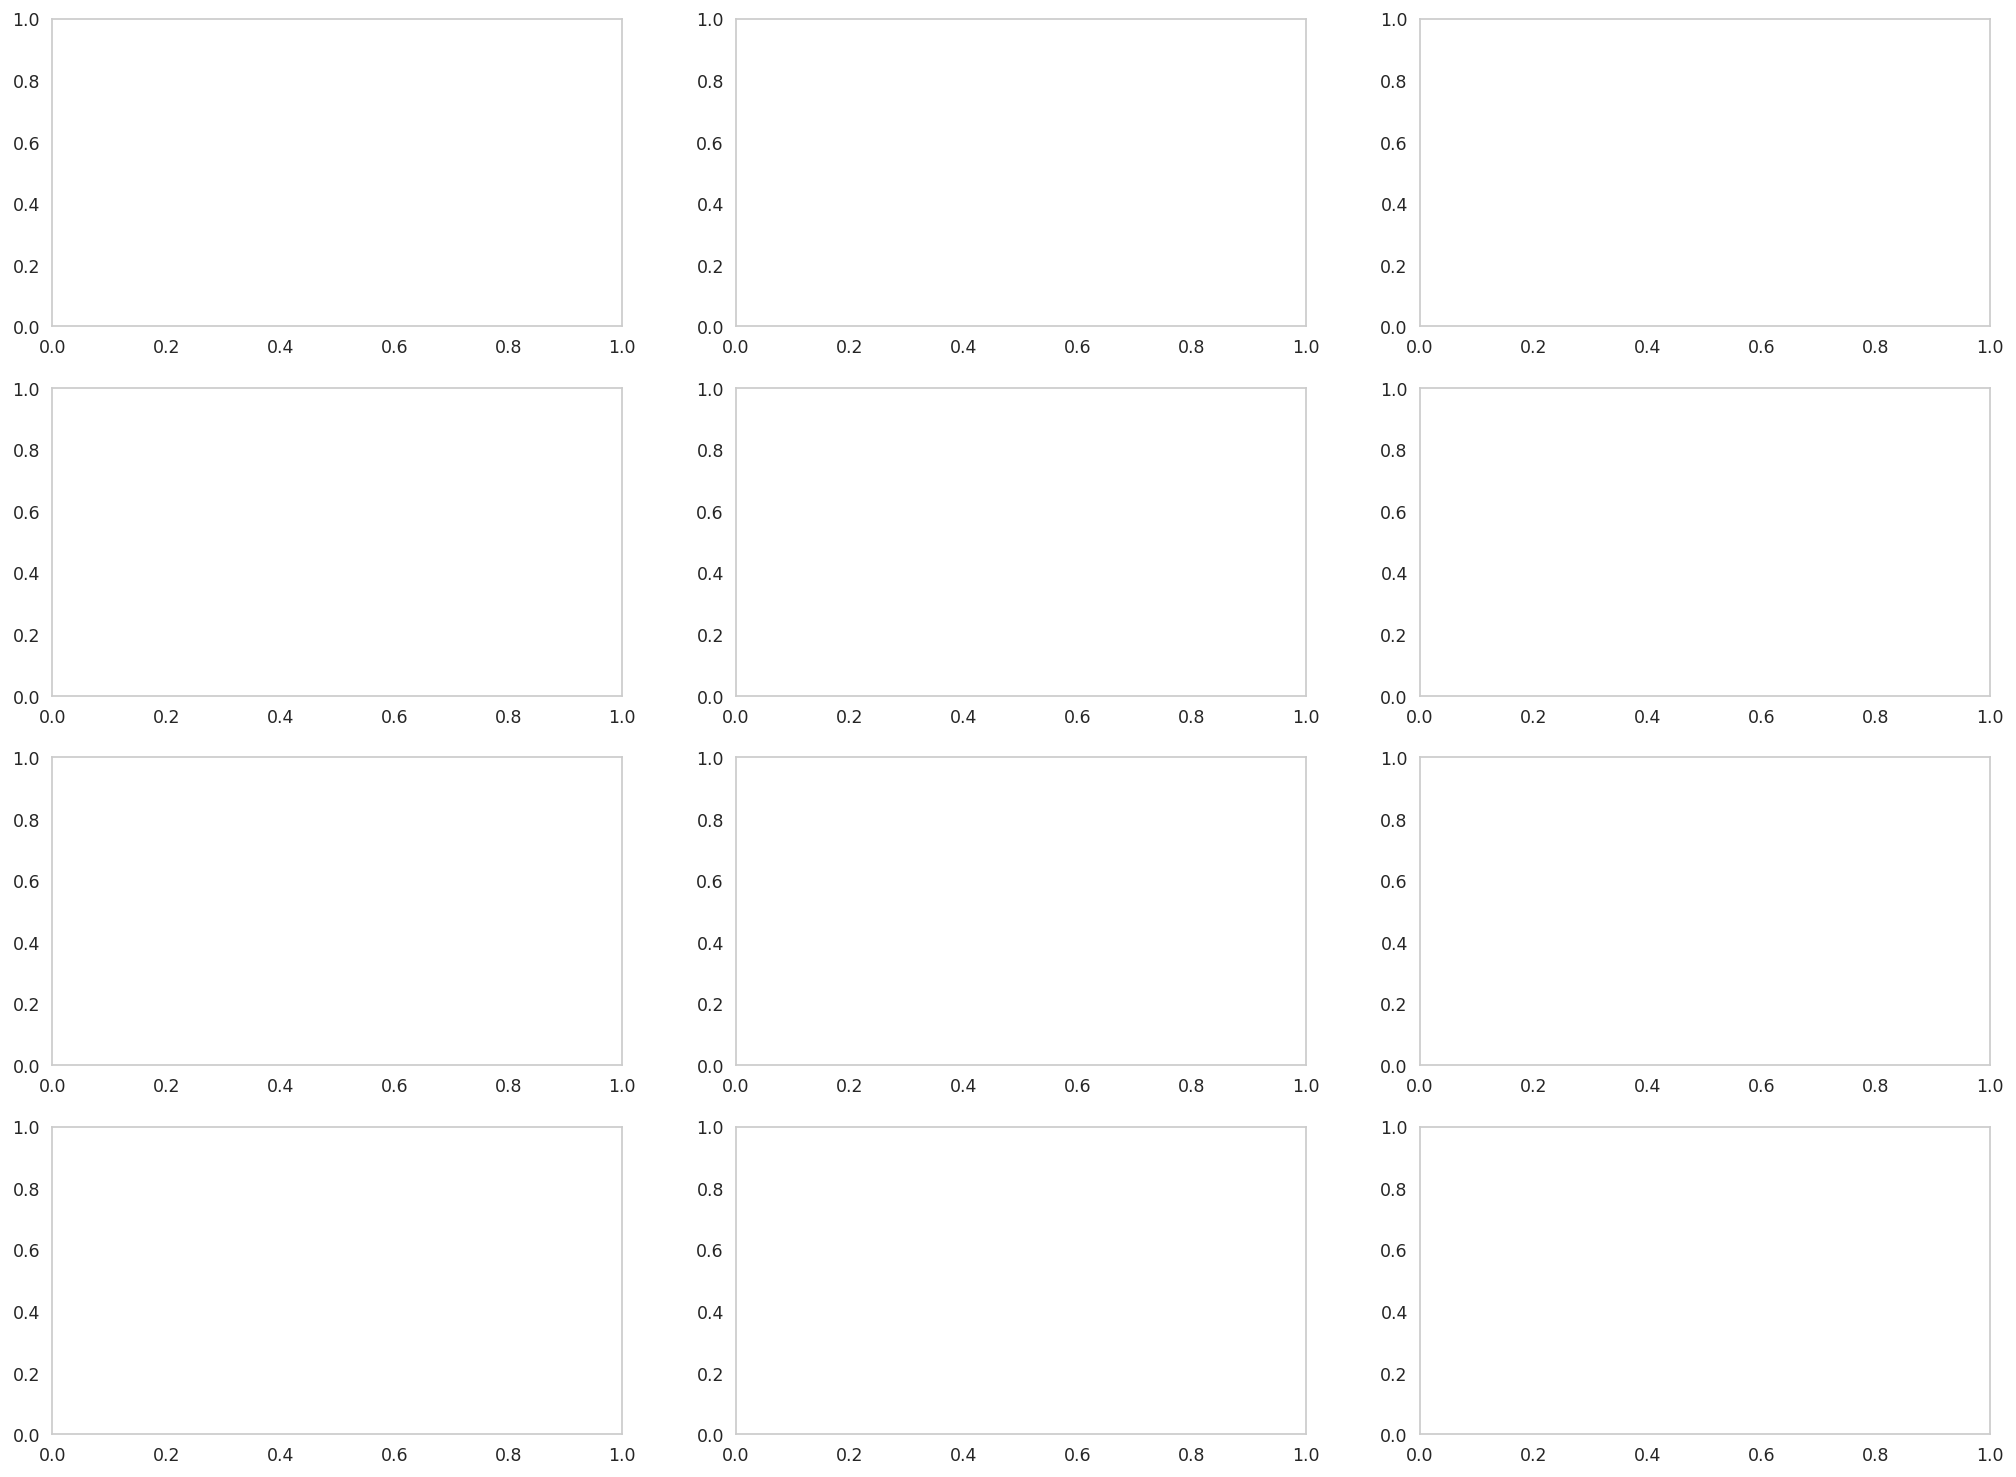

In [17]:
fig, m_axs = plt.subplots(4, 3, figsize=(20, 15))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(X_test[i].reshape((28, 28)))
    gc_stack = gc1_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax2.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax2.set_title(i_model.output_names[0])
    gc_stack = gc2_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax3.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax3.set_title(i_model.output_names[1])